# **IT2011 - End-to-End Preprocessing Pipeline**

This notebook combines the work of all group members into a single, integrated pipeline. It takes the raw student depression dataset and processes it through cleaning, encoding, outlier removal, scaling, feature selection, and dimensionality reduction.

**Group Members & Roles:**
- **Handling Missing Values:** Dinuka
- **Encoding:** Kavisha
- **Outlier Removal:** Parami
- **Scaling:** Sakitha
- **Feature Selection:** Hiruna
- **PCA (Dimensionality Reduction):** Janith

# **0. Initial Setup**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
!pip install category_encoders
import category_encoders as ce

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.4 MB/s eta 0:00:00


# **1. Load Data & Handle Missing Values (Contribution: Dinuka)**


**Objective:** To ensure the dataset is complete by addressing any missing data points, which can cause errors and lead to biased models.

**Technique:** We use **Median Imputation**. After identifying that the `Financial Stress` column had a few null values, we chose to fill them with the median. The median is robust to outliers and is a safe choice for maintaining the feature's original distribution.

In [2]:
#Load the dataset
df = pd.read_csv('Student Depression Dataset.csv')

In [3]:
#Separate into Features (X) and Target (y)
y = df['Depression']
X = df.drop(columns=['Depression'], errors='ignore')

In [4]:
#Find the missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Financial Stress    3
dtype: int64


/tmp/ipython-input-1274110308.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")


 'missing_values_before.png' has been saved.


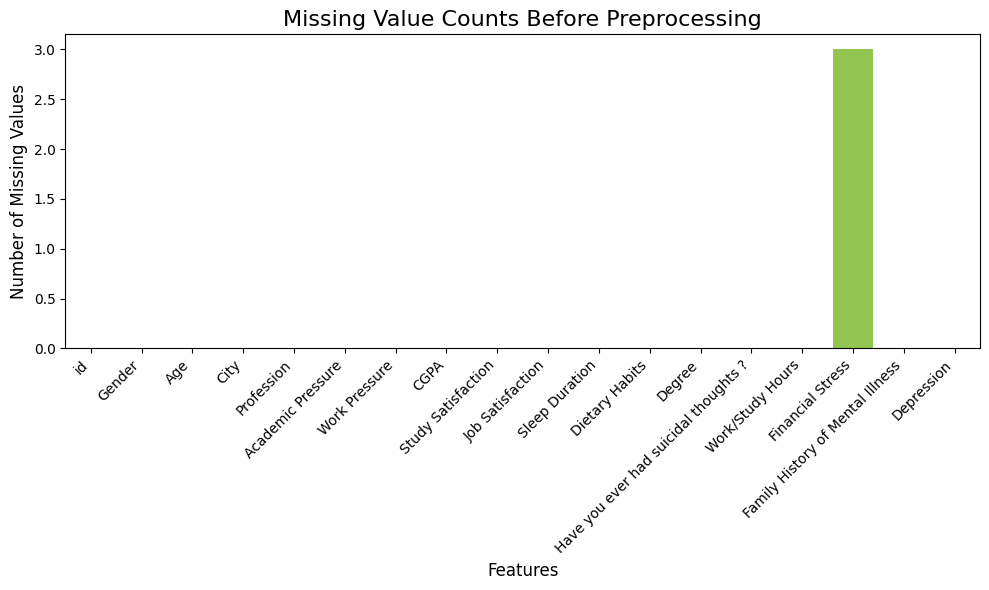

In [5]:
#Create the bar chart to show the missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Missing Value Counts Before Preprocessing', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.tight_layout() # Adjust layout to make room for labels
plt.savefig('missing_values_before.png')
print(" 'missing_values_before.png' has been saved.")
plt.show()

In [6]:
#Fill missing numerical values with the MEDIAN
numerical_cols = X.select_dtypes(include=np.number).columns
for col in numerical_cols:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"Filled missing values in '{col}' with median: {median_val}")

Filled missing values in 'Financial Stress' with median: 3.0


In [7]:
#Verify that all missing values have been handled
print(f"\nTotal missing values remaining in X: {X.isnull().sum().sum()}")


Total missing values remaining in X: 0


In [8]:
#combine X and Y
df = pd.concat([X, y], axis=1)

/tmp/ipython-input-3924550181.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_after.index, y=missing_after.values, palette="plasma")


 'missing_values_after.png' has been saved.


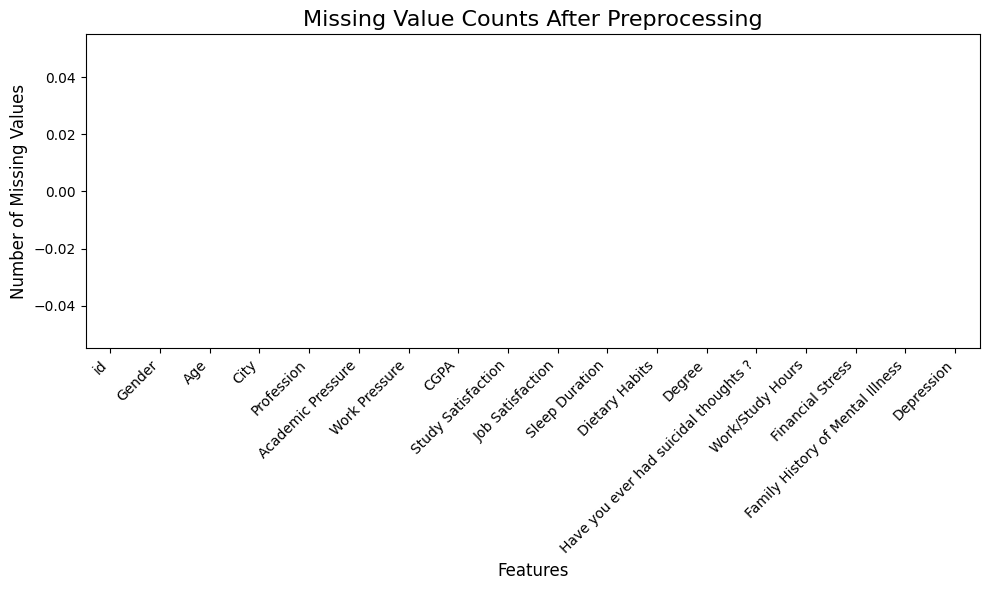

In [9]:
#Create a plot to visually confirm that no missing values are left
plt.figure(figsize=(10, 6))
missing_after = df.isnull().sum()
sns.barplot(x=missing_after.index, y=missing_after.values, palette="plasma")
plt.xticks(rotation=45, ha='right')
plt.title('Missing Value Counts After Preprocessing', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.tight_layout()
plt.savefig('missing_values_after.png')
print(" 'missing_values_after.png' has been saved.")
plt.show()


# **2. Categorical Feature Encoding (Contribution: Kavisha)**



**Objective:** To convert non-numeric text data (like 'Gender' or 'City') into a numerical format that machine learning models can process.

**Technique:** We use a multi-step strategy based on the type of feature:
* **Binary Mapping:** For features with two categories (e.g., 'Yes'/'No'), we map them directly to `1` and `0`.
* **Ordinal Encoding:** For features with a clear order (e.g., 'Sleep Duration'), this preserves the ranking information.
* **Target Encoding:** For high-cardinality features like `City`, this advanced method replaces each category with its average target value, capturing predictive power without creating too many new columns. This is performed *after* the train-test split to prevent data leakage.

In [10]:
# Drop the id colum
if 'id' in df.columns:
    df = df.drop('id', axis=1)

/tmp/ipython-input-2160416623.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_depression_mean.index, y=city_depression_mean.values, palette="viridis")


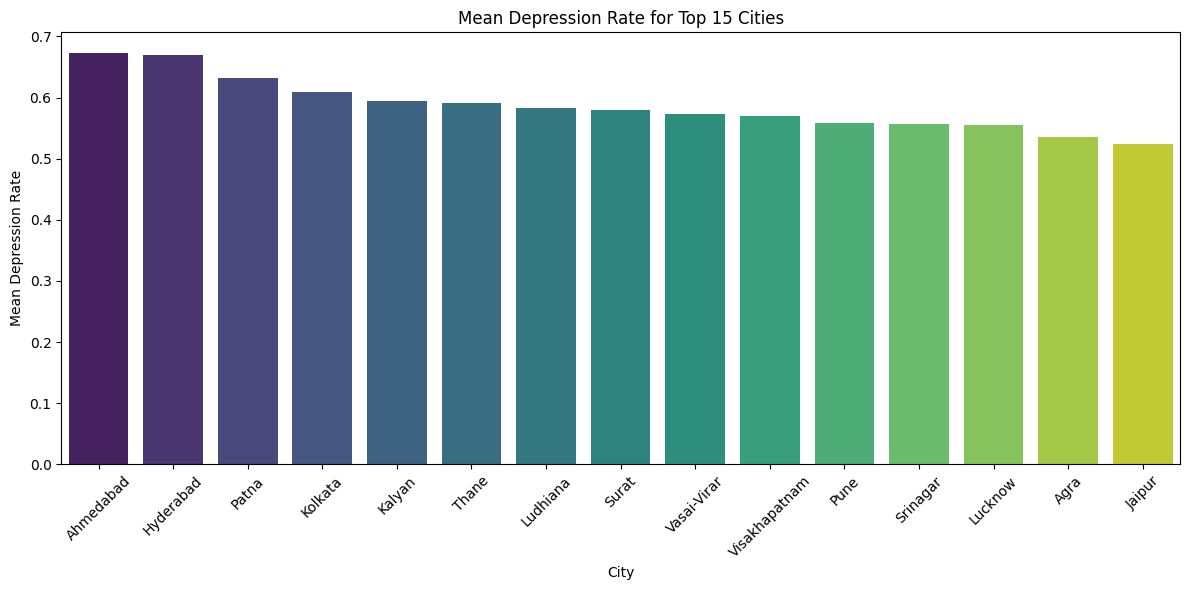

In [11]:
#EDA: Analyzing Categorical Feature Impact on Depression
top_cities = df['City'].value_counts().nlargest(15).index
city_depression_mean = df[df['City'].isin(top_cities)].groupby('City')['Depression'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=city_depression_mean.index, y=city_depression_mean.values, palette="viridis")
plt.title('Mean Depression Rate for Top 15 Cities')
plt.xlabel('City')
plt.ylabel('Mean Depression Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1142927342.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sleep_depression_mean.index, y=sleep_depression_mean.values, palette="plasma")


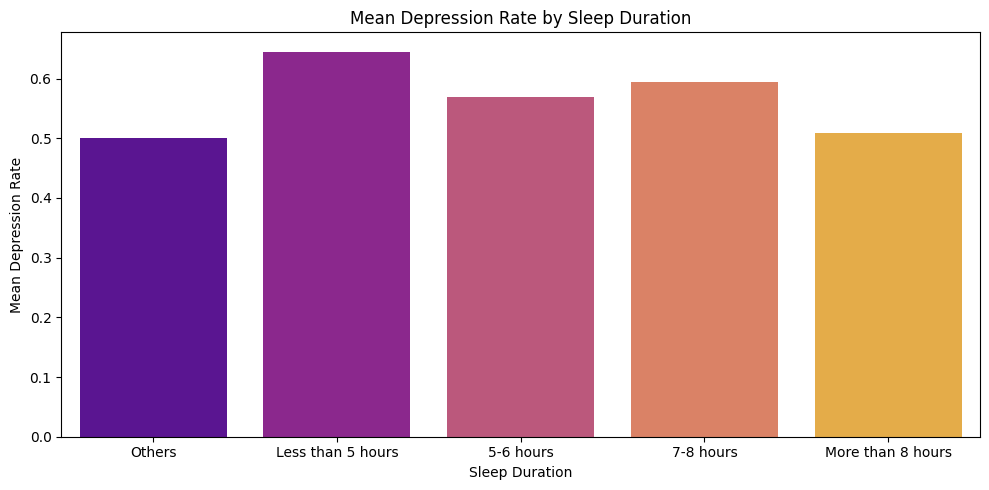

In [12]:
sleep_order = ['Others', 'Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours']
sleep_depression_mean = df.groupby('Sleep Duration')['Depression'].mean().reindex(sleep_order)

plt.figure(figsize=(10, 5))
sns.barplot(x=sleep_depression_mean.index, y=sleep_depression_mean.values, palette="plasma")
plt.title('Mean Depression Rate by Sleep Duration')
plt.xlabel('Sleep Duration')
plt.ylabel('Mean Depression Rate')
plt.tight_layout()
plt.show()

Starting Data Encodin

In [13]:
df_encoded = df.copy()

In [14]:
#Encoding binary features
# Gender: Male=1, Female=0
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

# Suicidal thoughts: Yes=1, No=0
df["Have you ever had suicidal thoughts ?"] = df["Have you ever had suicidal thoughts ?"].map({"Yes": 1, "No": 0})

# Family history: Yes=1, No=0
df["Family History of Mental Illness"] = df["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

In [15]:
#Encoding Ordinal features
# Sleep Duration (example: "5-6 hours"=1, else=0 → adjust if needed)
df["Sleep Duration"] = df["Sleep Duration"].map({
    "Less than 5 hours": 0,
    "5-6 hours": 1,
    "7-8 hours": 2,
    "More than 8 hours": 3
})

# Dietary Habits: Healthy=1, else=0
df["Dietary Habits"] = df["Dietary Habits"].map({
    "Healthy": 0,
    "Moderate": 1,
    "Unhealthy": 3
})

In [16]:
#Split Data BEFORE Target Encoding
X = df.drop('Depression', axis=1)
y = df['Depression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 22320, Testing samples: 5581


In [17]:
#Target Encode High-Cardinality Features
high_card_cols = ['City', 'Profession', 'Degree']

target_encoder = ce.TargetEncoder(cols=high_card_cols)
target_encoder.fit(X_train, y_train)

X_train = target_encoder.transform(X_train)
X_test = target_encoder.transform(X_test)

In [18]:
#verifying encoding
display(X_train.head())

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
13048,1,28.0,0.530909,0.586499,2.0,0.0,8.29,5.0,0.0,1.0,1.0,0.548458,0,4.0,1.0,1
24535,0,33.0,0.620647,0.586499,4.0,0.0,9.05,4.0,0.0,0.0,0.0,0.538333,0,12.0,4.0,1
15303,0,33.0,0.519802,0.586499,4.0,0.0,8.08,4.0,0.0,0.0,0.0,0.523702,1,12.0,3.0,0
22444,0,29.0,0.546351,0.586499,2.0,0.0,5.76,4.0,0.0,1.0,1.0,0.501515,0,10.0,2.0,1
18744,0,20.0,0.593861,0.586499,5.0,0.0,5.77,5.0,0.0,2.0,1.0,0.711325,1,11.0,5.0,0


# **3. Outlier Removal from Training Data (Contribution: Parami)**


**Objective:** To identify and remove extreme data points (outliers) from the training set that could negatively skew the model's learning process.

**Technique:** We apply the **Interquartile Range (IQR) Method**. This robust statistical technique identifies any data point that falls significantly outside the central 50% of the data. This is performed **only on the training data** to prevent any information from the test set from leaking into our preprocessing decisions.

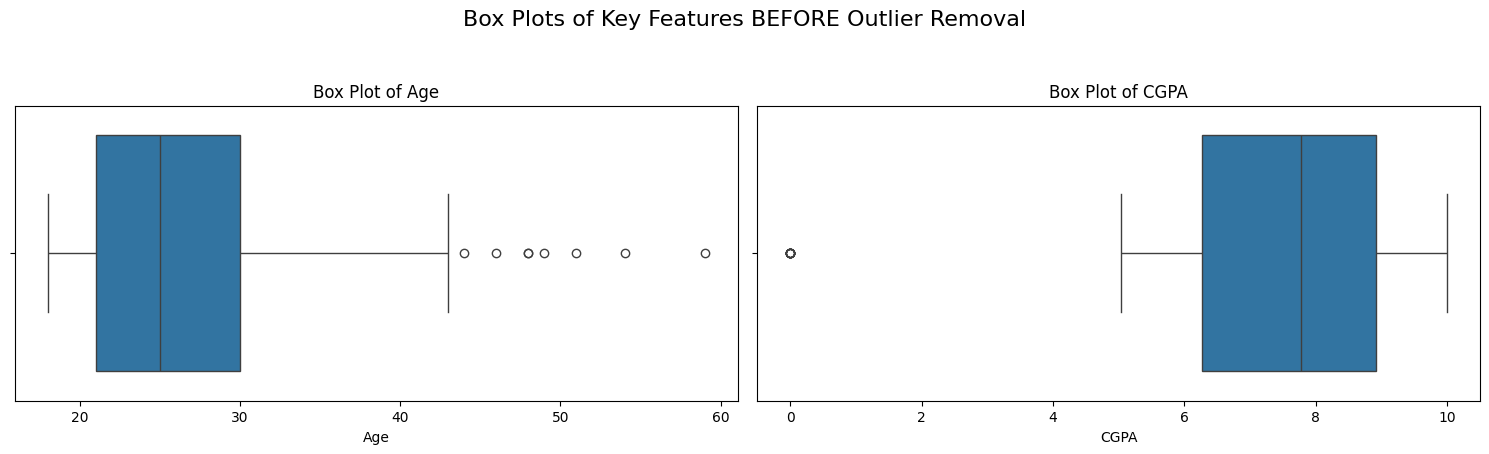

In [19]:
#EDA - Visualize Outliers with Box Plots (Before Removal)

# Select key numerical features to inspect for outliers
# We only inspect the TRAINING data
features_to_check = ['Age', 'CGPA']

plt.figure(figsize=(15, 8))
plt.suptitle("Box Plots of Key Features BEFORE Outlier Removal", fontsize=16)

for i, feature in enumerate(features_to_check):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=X_train[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [20]:
#Identify and Remove Outliers from the Training Set
print("\n--- Identifying and removing outliers from the training data only ---")

# Select only the numerical columns for IQR calculation
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = X_train[numerical_cols].quantile(0.25)
Q3 = X_train[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows that contain outliers in any of the numerical columns
outlier_mask = ((X_train[numerical_cols] < lower_bound) | (X_train[numerical_cols] > upper_bound)).any(axis=1)

# Get the indices of the outlier rows
outlier_indices = X_train[outlier_mask].index

print(f"Original number of samples in training data: {len(X_train)}")
print(f"Number of outliers detected: {len(outlier_indices)}")

# Remove the outliers from both X_train and y_train
X_train= X_train.drop(outlier_indices)
y_train= y_train.drop(outlier_indices)

print(f"New number of samples in training data: {len(X_train)}")
print(f"Shape of X_test (unchanged): {X_test.shape}")


--- Identifying and removing outliers from the training data only ---
Original number of samples in training data: 22320
Number of outliers detected: 4909
New number of samples in training data: 17411
Shape of X_test (unchanged): (5581, 16)


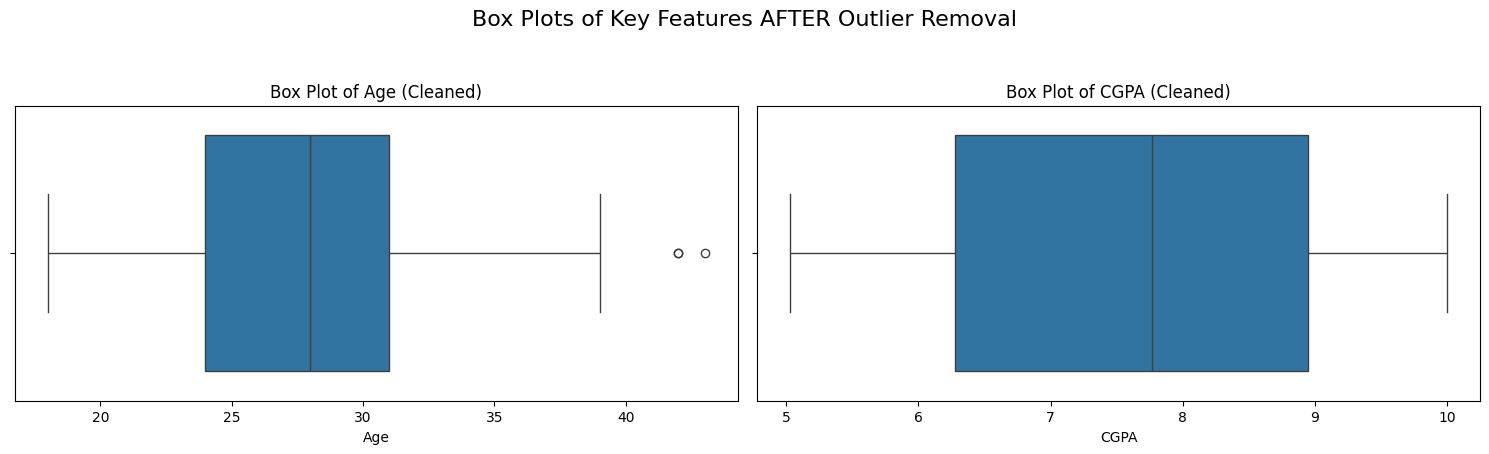

In [21]:
# EDA - Visualize Data with Box Plots (After Removal)
plt.figure(figsize=(15, 8))
plt.suptitle("Box Plots of Key Features AFTER Outlier Removal", fontsize=16)

for i, feature in enumerate(features_to_check):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=X_train[feature])
    plt.title(f'Box Plot of {feature} (Cleaned)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

This is because the box plot's boundaries are recalculated based on the new, tighter distribution of the cleaned data. These remaining points are not extreme and removing them further could risk deleting valuable data. Therefore, we made a conscious decision to perform only one pass of outlier removal to eliminate the most influential outliers while preserving the integrity of the dataset. The resulting data is now more robust for model training

# **4. Feature Scaling (Contribution: Sakitha)**

**Objective:** To standardize the range of all numerical features so that they contribute equally to the model, preventing features with larger scales (like `Age`) from unfairly dominating those with smaller scales (like `CGPA`).

**Technique:** We use **Standardization** (`StandardScaler`). This technique transforms each feature to have a mean of 0 and a standard deviation of 1. The scaler is fitted *only* on the training data to learn the parameters, which are then applied to both the training and test sets to ensure consistency and prevent data leakage.

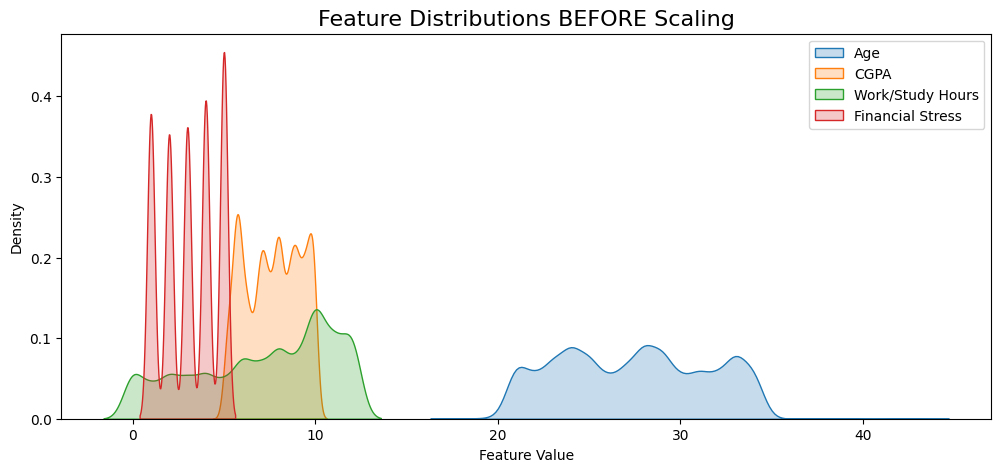

In [22]:
#EDA - Visualize Feature Distributions (Before Scaling)

# Select the same key numerical features for consistency
features_to_plot = ['Age', 'CGPA', 'Work/Study Hours', 'Financial Stress']

plt.figure(figsize=(12, 5))
plt.title("Feature Distributions BEFORE Scaling", fontsize=16)
for feature in features_to_plot:
    sns.kdeplot(X_train[feature], label=feature, fill=True)
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [23]:
#Apply StandardScaler to Numerical Features
print("\n--- Applying StandardScaler ---")

# Initialize the scaler
scaler = StandardScaler()

# Identify all numerical columns to be scaled
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Fit the scaler on the TRAINING data and transform it
# This learns the mean and std dev from the training set only
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])

# Use the SAME fitted scaler to transform the TEST data
# We do NOT fit again on the test data to avoid data leakage
X_test_scaled = scaler.transform(X_test[numerical_cols])

# Convert the scaled arrays back to DataFrames to keep column names
X_train = pd.DataFrame(X_train_scaled, columns=numerical_cols)
X_test = pd.DataFrame(X_test_scaled, columns=numerical_cols)

print("Scaling complete. Displaying the first 5 rows of the scaled training data:")
display(X_train.head())


--- Applying StandardScaler ---
Scaling complete. Displaying the first 5 rows of the scaled training data:


,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,0.889111,0.151151,-1.402300,-2.220446e-16,-0.779413,0.0,0.423719,1.544157,0.0,-0.350215,-0.359029,-0.125874,-1.273012,-0.832188,-1.453043,1.034778
1,-1.124719,1.396506,0.894345,-2.220446e-16,0.653873,0.0,0.938558,0.806583,0.0,-1.242111,-1.168497,-0.480612,-1.273012,1.309051,0.622057,1.034778
2,-1.124719,1.396506,-1.686563,-2.220446e-16,0.653873,0.0,0.281462,0.806583,0.0,-1.242111,-1.168497,-0.993241,0.785538,1.309051,-0.069643,-0.966391
3,-1.124719,0.400222,-1.007095,-2.220446e-16,-0.779413,0.0,-1.290150,0.806583,0.0,-0.350215,-0.359029,-1.770590,-1.273012,0.773741,-0.761343,1.034778
4,0.889111,-0.097920,0.240675,-2.220446e-16,0.653873,0.0,1.067267,-0.668566,0.0,0.541680,1.259906,-0.125874,0.785538,-0.832188,-0.761343,1.034778


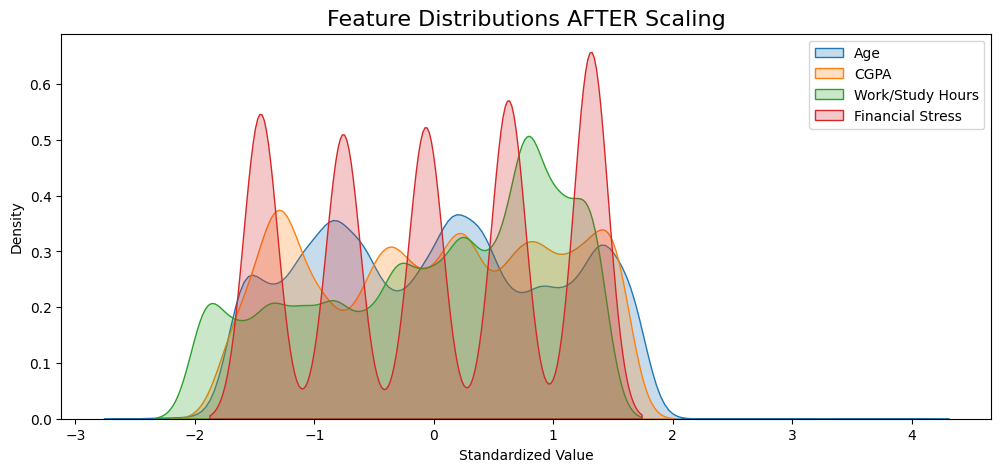

In [24]:
#EDA - Visualize Feature Distributions (After Scaling)
plt.figure(figsize=(12, 5))
plt.title("Feature Distributions AFTER Scaling", fontsize=16)
for feature in features_to_plot:
    sns.kdeplot(X_train[feature], label=feature, fill=True)
plt.xlabel("Standardized Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# **5. Feature Selection (Contribution: Hiruna)**



**Objective:** To select only the most relevant features for predicting depression, which improves model accuracy, reduces overfitting, and enhances interpretability.

**Technique:**

1.  **Correlation Filter (for Redundancy):** We first ran a correlation analysis to check for multicollinearity. Our analysis found no features with a correlation coefficient higher than our 0.8 threshold, indicating there was no significant redundancy in our dataset.

2.  **ANOVA F-test (for Relevance):** We then used the ANOVA F-test as our primary filter method. This statistical test ranks features based on their individual relevance to the `Depression` target. We selected the **top 12 features** that had the highest F-scores, meaning they have the strongest statistical relationship with the outcome.

3.  **Random Forest (for Validation):** To validate our statistical selection, we also ran an embedded method using a Random Forest model as a secondary check. The feature importance rankings produced by the Random Forest closely mirrored the results of the ANOVA F-test, with the same features appearing at the top. This strong agreement between a statistical filter and a model-based method gave us high confidence that we had selected the most impactful and relevant features for our final model.

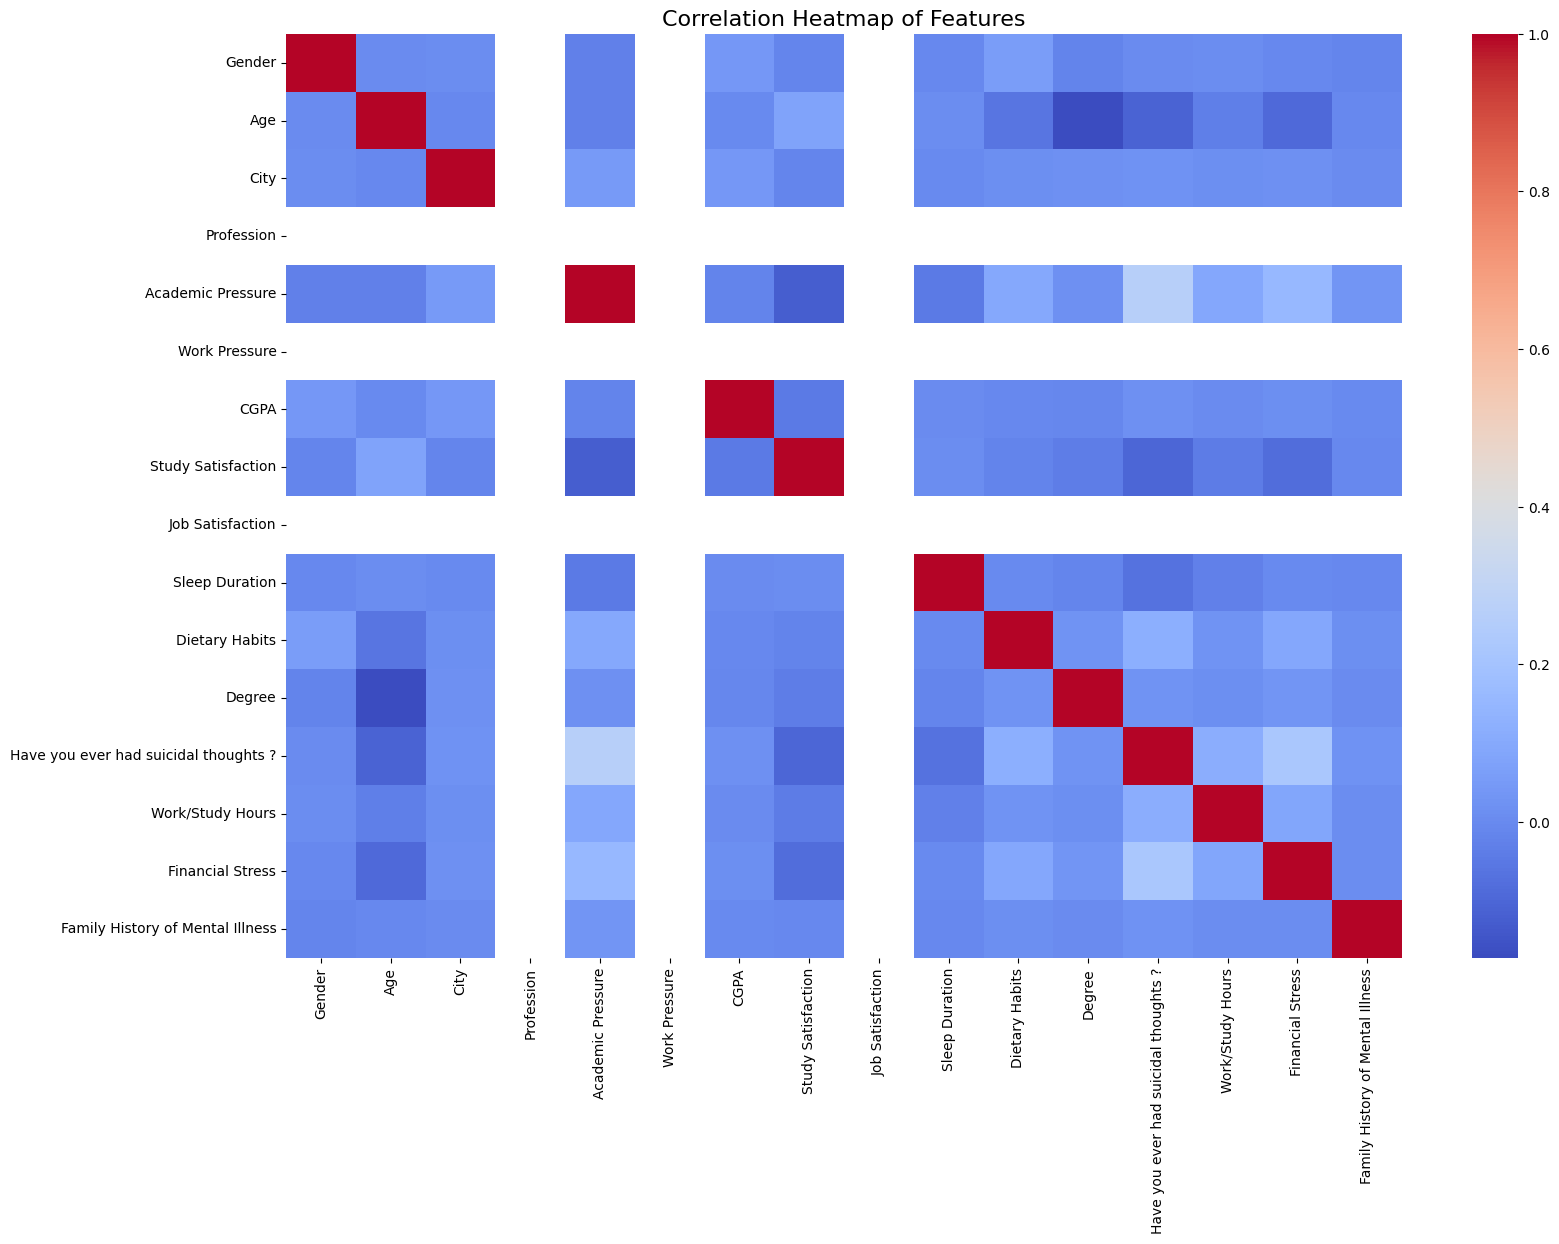


No features with correlation > 0.8 found to drop.
Shape of training data after correlation check: (17411, 16)


In [25]:
#Correlation Analysis

plt.figure(figsize=(18, 12))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.show()

# --- Find and remove highly correlated features ---
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.8 (a common threshold)
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

if not to_drop:
    print("\nNo features with correlation > 0.8 found to drop.")
else:
    print(f"\nDropping features with correlation > 0.8: {to_drop}")
    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)

print("Shape of training data after correlation check:", X_train.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


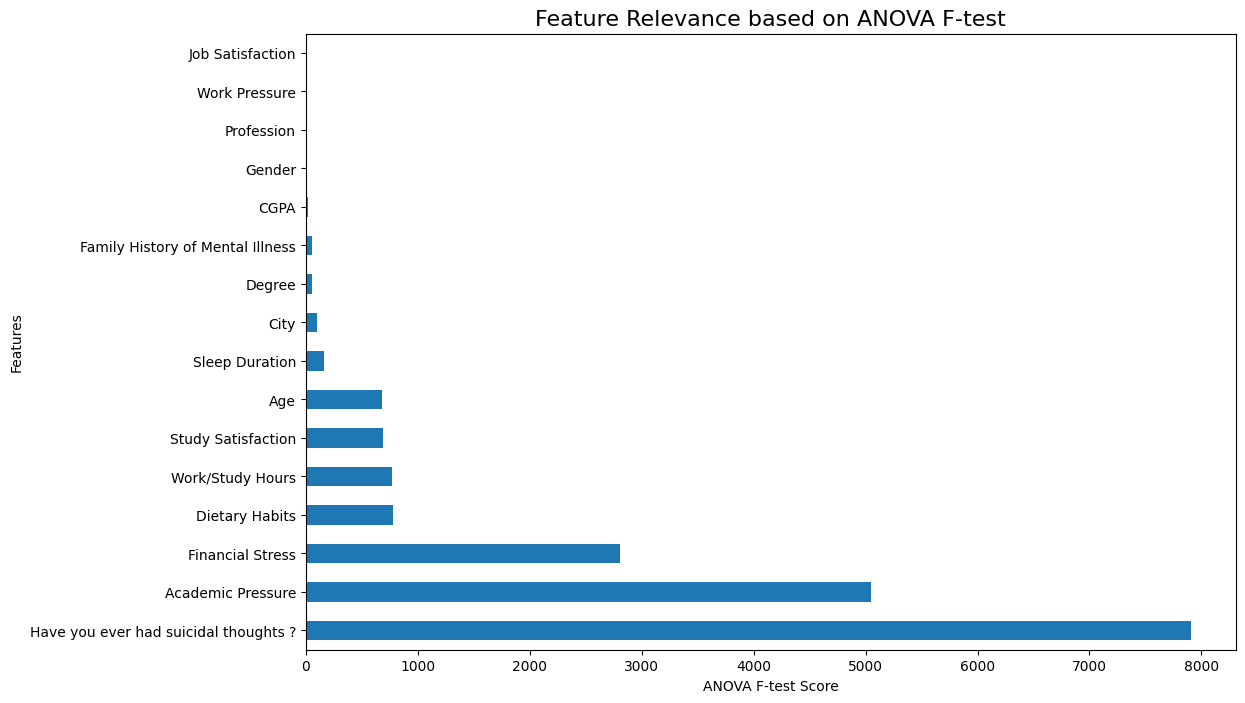


Kept the top 12 features based on F-scores.
Shape of data after ANOVA filter: (17411, 12)


In [26]:
# Step 3: Filter for Relevance using ANOVA F-test

# Use SelectKBest to get the F-scores for all features
imputer = SimpleImputer(strategy='mean')

# Fit on the training data and transform both sets
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

f_selector = SelectKBest(score_func=f_classif, k='all')
f_selector.fit(X_train, y_train)
f_scores = pd.Series(f_selector.scores_, index=X_train.columns)

# --- EDA: Visualize the F-scores ---
# This is a key visualization for this new method.
plt.figure(figsize=(12, 8))
f_scores.sort_values(ascending=False).plot(kind='barh')
plt.xlabel("ANOVA F-test Score")
plt.ylabel("Features")
plt.title("Feature Relevance based on ANOVA F-test", fontsize=16)
plt.show()

# --- Prune the dataset based on F-scores ---
# We will keep the top 12 features to pass to the next stage
# This filters out the least statistically relevant features first.
top_12_f_features = f_scores.nlargest(12).index.tolist()
X_train_anova = X_train[top_12_f_features]
X_test_anova = X_test[top_12_f_features]

print(f"\nKept the top 12 features based on F-scores.")
print("Shape of data after ANOVA filter:", X_train_anova.shape)

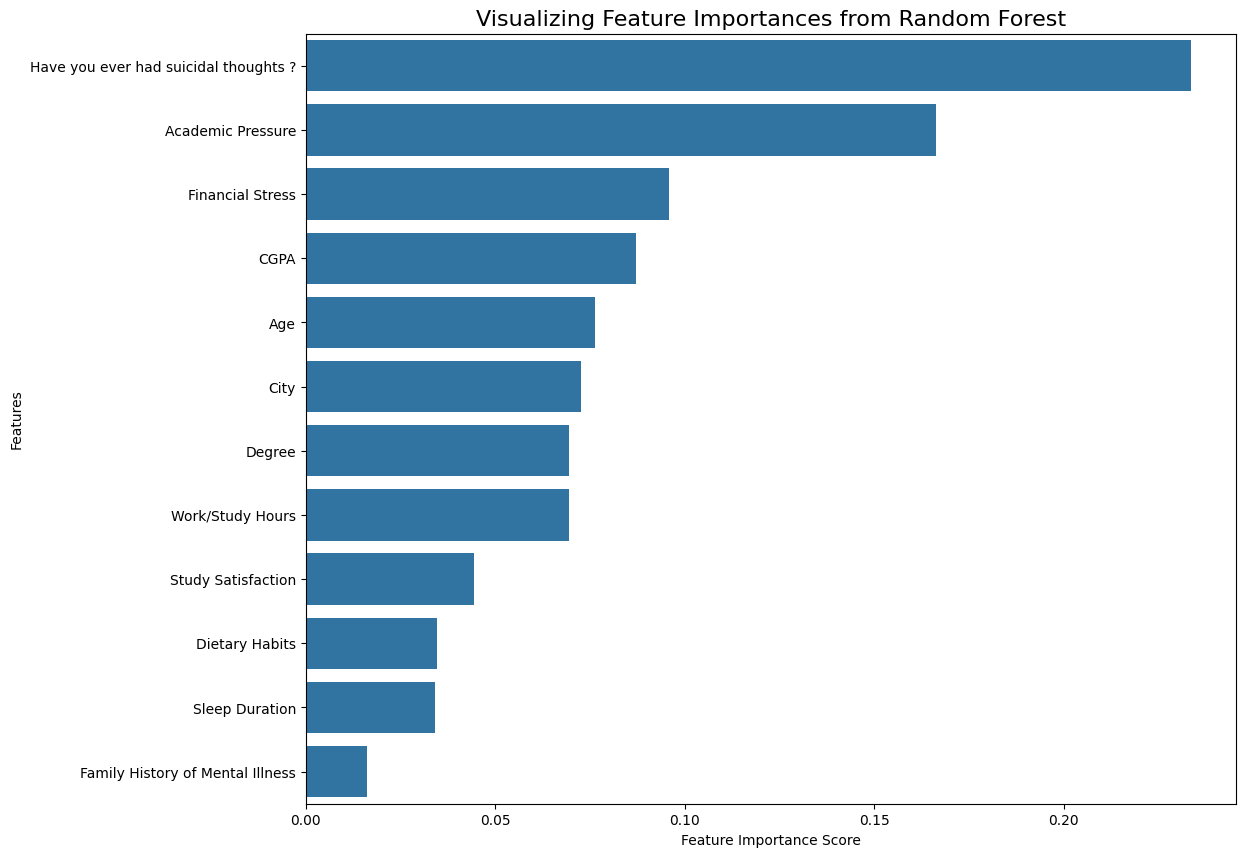

Feature Importances:
Have you ever had suicidal thoughts ?    0.233619
Academic Pressure                        0.166152
Financial Stress                         0.095932
CGPA                                     0.087116
Age                                      0.076258
City                                     0.072626
Degree                                   0.069528
Work/Study Hours                         0.069383
Study Satisfaction                       0.044470
Dietary Habits                           0.034547
Sleep Duration                           0.034223
Family History of Mental Illness         0.016146
dtype: float64


In [28]:
#Random Forest Feature Importance

# Train a RandomForestClassifier to get feature importance scores
# random_state ensures reproducibility
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train_anova, y_train)

# Create a pandas Series for easy plotting
importances = pd.Series(model_rf.feature_importances_, index=X_train_anova.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# --- EDA: Visualize Feature Importances ---
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Feature Importances from Random Forest", fontsize=16)
plt.show()

print("Feature Importances:")
print(sorted_importances)

In [29]:
#Selecting the Final Set of Features

# We will select the top 12 most important features as an example
# No changing in features on the random forest RandomForestClassifier ( just an example)

N_FEATURES = 12
final_features = sorted_importances.nlargest(N_FEATURES).index.tolist()

print(f"\nSelected Top {N_FEATURES} Features: \n{final_features}")

# Create the final datasets with only the selected features
X_train_final = X_train_anova[final_features]
X_test_final = X_test_anova[final_features]

print(f"\nFinal shape of training data: {X_train_final.shape}")


Selected Top 12 Features: 
['Have you ever had suicidal thoughts ?', 'Academic Pressure', 'Financial Stress', 'CGPA', 'Age', 'City', 'Degree', 'Work/Study Hours', 'Study Satisfaction', 'Dietary Habits', 'Sleep Duration', 'Family History of Mental Illness']

Final shape of training data: (17411, 12)


# **6. PCA for Visualization (Contribution: Janith)**

**Objective:** To reduce the dimensionality of our final feature set from 12 features down to 2 principal components. This step is performed **solely for visualization purposes**, allowing us to create a 2D scatter plot to observe the separation between classes.

**Technique:** We use **Principal Component Analysis (PCA)**. This method creates new, composite features (PC1 and PC2) that capture the maximum possible variance from the original 12 features, giving us the most informative 2D summary of our data.

In [30]:
#Apply PCA

# Initialize PCA. We set n_components=None to first see how much variance
# each of the possible components explains.
pca = PCA(n_components=None, random_state=42)

# Fit the PCA model on the TRAINING data only
pca.fit(X_train)

# Transform both the training and testing data using the fitted model
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("PCA transformation complete.")

PCA transformation complete.


PCA Explained Variance Summary:


,PC,Explained Variance (%),Cumulative Variance (%)
0,PC1,12.87,12.87
1,PC2,8.75,21.63
2,PC3,8.30,29.92
3,PC4,7.94,37.86
4,PC5,7.74,45.59
5,PC6,7.70,53.29
6,PC7,7.56,60.85
7,PC8,7.34,68.19
8,PC9,7.11,75.30
9,PC10,6.71,82.01


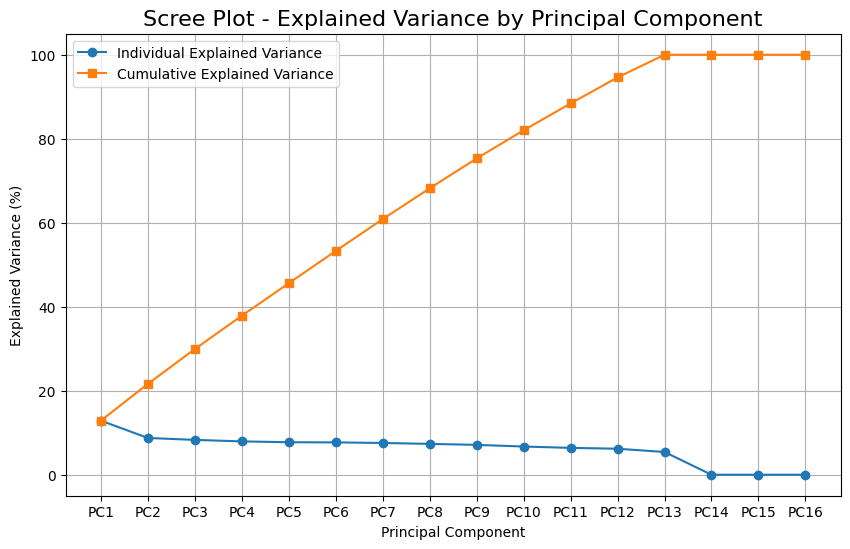

In [31]:
#EDA - Visualize Explained Variance with a Scree Plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create a summary DataFrame
pca_summary = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained_variance_ratio))],
    "Explained Variance (%)": explained_variance_ratio * 100,
    "Cumulative Variance (%)": cumulative_variance_ratio * 100
})

print("PCA Explained Variance Summary:")
display(pca_summary.round(2))

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(pca_summary["PC"], pca_summary["Explained Variance (%)"], marker='o', label="Individual Explained Variance")
plt.plot(pca_summary["PC"], pca_summary["Cumulative Variance (%)"], marker='s', label="Cumulative Explained Variance")
plt.title("Scree Plot - Explained Variance by Principal Component", fontsize=16)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.legend()
plt.grid(True)
plt.show()

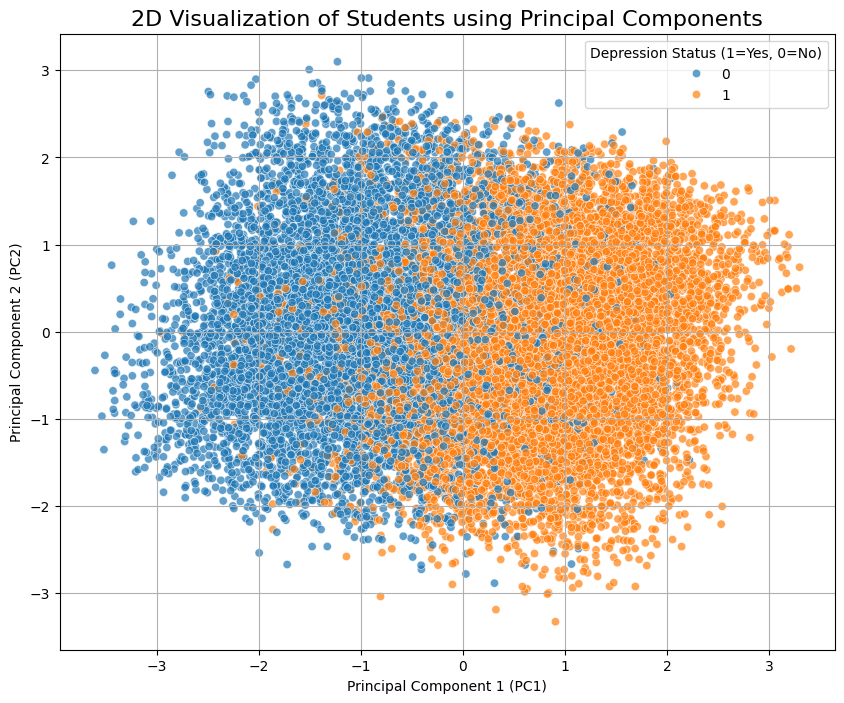

In [32]:
#EDA - Visualize Data in 2D PCA Space

# Create a DataFrame for plotting with seaborn
df_train_pca = pd.DataFrame(data=X_train_pca[:, :2], columns=['PC1', 'PC2'])
df_train_pca['Depression'] = y_train.values # Add the target variable for coloring

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Depression', data=df_train_pca, alpha=0.7)
plt.title("2D Visualization of Students using Principal Components", fontsize=16)
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend(title='Depression Status (1=Yes, 0=No)')
plt.grid(True)
plt.show()

In [33]:
print("\n✅ End-to-end preprocessing pipeline complete.")


✅ End-to-end preprocessing pipeline complete.


# **Save the Final Data for the Next Handoff (Model Training)**

In [34]:
# Save the final, feature-selected datasets
X_train_final.to_csv('X_train_final.csv', index=False)
X_test_final.to_csv('X_test_final.csv', index=False)

# Pass along the corresponding labels (these haven't changed)
y_train.to_csv('y_train_final.csv', index=False)
y_test.to_csv('y_test_final.csv', index=False)

print("\n Handoff successful! Final feature-selected datasets have been saved.")


 Handoff successful! Final feature-selected datasets have been saved.
